In [ ]:
if __name__ == "__main__":
    star_dir = 'RULup'
    file_name = 'crires_4645nm_4978nm_Vstar_RU_LUP.fits'
    base_folder = os.path.dirname(os.path.abspath(__file__))
    data_folder = os.path.join(base_folder, 'data_products', '2022_07_24', star_dir)
    abs_path = os.path.join(data_folder, file_name)
    example_data = SpexodFITS(abs_path)

In [2]:
import os

import numpy as np
from astropy.io import fits


def fits_headers_to_dict(header):
    header_dict = {}
    for key, value in header.items():
        if key in header_dict.keys():
            header_dict[key] += " | " + value
        else:
            header_dict[key] = value
    return header_dict


def get_fits(path):
    hdul = fits.open(path)
    return hdul


def hdu_table_to_struct_array(hdu):
    dtype_list = hdu.data.dtype.descr
    return np.array(hdu.data, dtype=dtype_list)


class SpexodFITS:
    dynamic_types = {'hitran', 'fluxcal', 'lineflux', 'stackedline'}

    def __init__(self, path):
        # settings for a single instance
        self.path = path
        # static data types
        self.hdul = get_fits(path)
        self.header = self.get_header()
        self.header_dict = fits_headers_to_dict(self.header)
        self.wavelength_um, self.flux, self.flux_error = self.get_spectrum()
        self.header_observation = self.get_header_observation()
        self.header_observation_dict = fits_headers_to_dict(self.header_observation)
        # Dynamically added data types
        # Table data is converted to a is stored as numpy structured array
        # https://numpy.org/doc/stable/user/basics.rec.html
        self.hitran_tables_by_molecule = None  # each dict key (molecule) has a value that is a numpy structured array
        self.fluxcal = None
        self.linefluxes_by_transition = None
        self.stackedlines_by_transition = None

        for dynamic_hdu in self.hdul[3:]:
            self.dynamic_hdu_parse(dynamic_hdu=dynamic_hdu)

    def get_header(self):
        return self.hdul[0].header

    def get_spectrum(self):
        return self.hdul[1].data['wavelength_um'], self.hdul[1].data['flux'], self.hdul[1].data['flux_error']

    def get_header_observation(self):
        return self.hdul[2].header

    def dynamic_hdu_parse(self, dynamic_hdu):
        dynamic_type = dynamic_hdu.header["DYNMTYPE"].lower()
        if dynamic_type in self.dynamic_types:
            self.__getattribute__(f'set_{dynamic_type}')(dynamic_hdu)
        else:
            raise TypeError(f'Dynamic Type: {dynamic_type} is not one of the ' +
                            f'allowed dynamic types {self.dynamic_types}')

    def set_hitran(self, hitran_hdu):
        if self.hitran_tables_by_molecule is None:
            self.hitran_tables_by_molecule = {}
        molecule = hitran_hdu.header['MOLETYPE'].strip().upper()
        self.hitran_tables_by_molecule[molecule] = hdu_table_to_struct_array(hdu=hitran_hdu)

    def set_fluxcal(self, fluxcal_hdu):
        self.fluxcal = hdu_table_to_struct_array(hdu=fluxcal_hdu)

    def set_lineflux(self, lineflux_hdu):
        if self.linefluxes_by_transition is None:
            self.linefluxes_by_transition = {}
        transition = lineflux_hdu.header['FLXTRANS'].strip().replace(' ', '').upper()
        self.linefluxes_by_transition[transition] = hdu_table_to_struct_array(hdu=lineflux_hdu)

    def set_stackedline(self, stackedline_hdu):
        if self.stackedlines_by_transition is None:
            self.stackedlines_by_transition = {}
        transition = stackedline_hdu.header['STKTRANS'].strip().replace(' ', '').upper()
        self.stackedlines_by_transition[transition] = hdu_table_to_struct_array(hdu=stackedline_hdu)



In [3]:
#from google.colab import drive
#drive.mount('/content/drive')
import matplotlib.pyplot as plt
!git clone https://github.com/mas940/data-analysis-taller/


Cloning into 'data-analysis-taller'...
remote: Enumerating objects: 188, done.
remote: Counting objects: 100% (188/188), done.
remote: Compressing objects: 100% (169/169), done.
remote: Total 188 (delta 85), reused 42 (delta 10), pack-reused 0 (from 0)
Receiving objects: 100% (188/188), 2.45 MiB | 5.65 MiB/s, done.
Resolving deltas: 100% (85/85), done.


In [4]:
if __name__ == "__main__":
    #star_dir = 'RULup'
    #file_name = 'crires_4645nm_4978nm_Vstar_RU_LUP.fits'
    #base_folder = '/data-analysis-taller/data/'#Path.cwd() # a fix for Google Colab specifically
    #data_folder = os.path.join(base_folder, 'data_products', '2022_07_24', star_dir)
    #abs_path = os.path.join(data_folder, file_name)
    example_data = SpexodFITS('data-analysis-taller/data/ishell_4517nm_5232nm_vstar_ru_lup.fits')

#Plotting Data
Plotting full spectra

<>:8: SyntaxWarning: invalid escape sequence '\m'
<>:9: SyntaxWarning: invalid escape sequence '\m'
<>:8: SyntaxWarning: invalid escape sequence '\m'
<>:9: SyntaxWarning: invalid escape sequence '\m'
/tmp/ipython-input-3916234415.py:8: SyntaxWarning: invalid escape sequence '\m'
  plt.xlabel('Wavelength ($\mu$m)', fontsize=20)
/tmp/ipython-input-3916234415.py:9: SyntaxWarning: invalid escape sequence '\m'
  plt.title('RU Lup 5 $\mu$m CO spectra', fontsize=25)


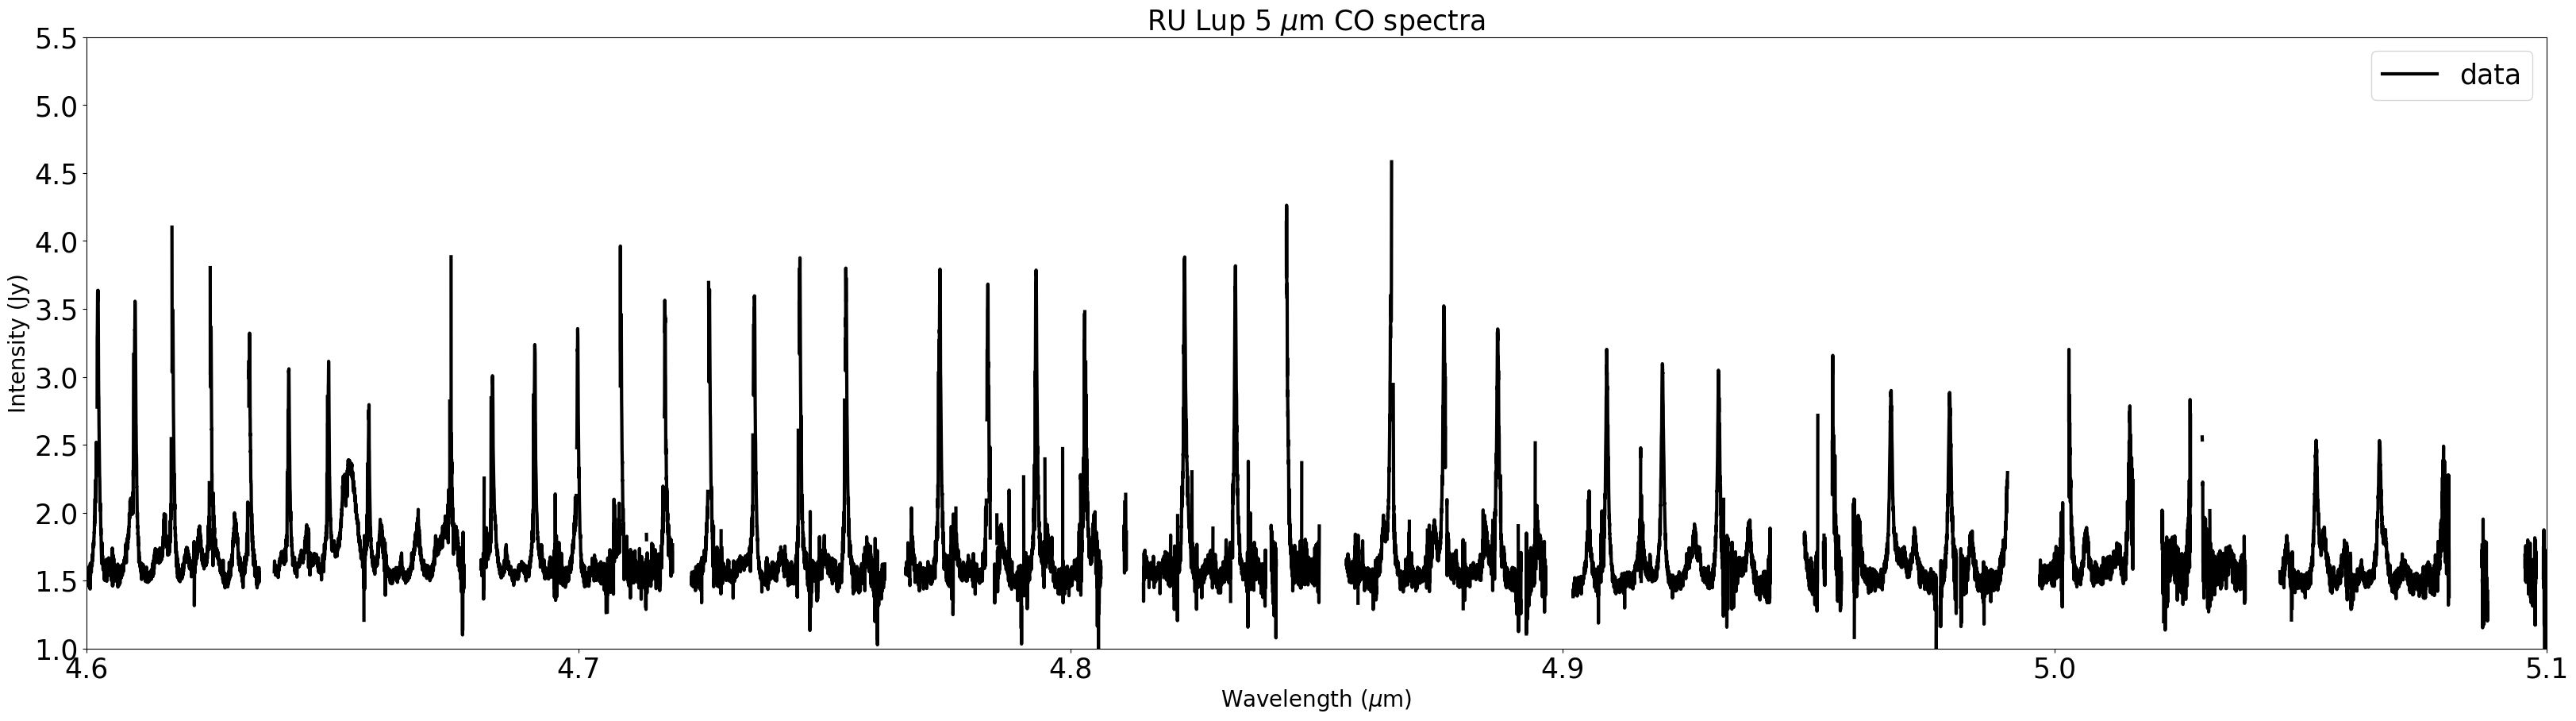

In [14]:
plt.figure(figsize=(40,10))
plt.plot(example_data.wavelength_um, example_data.flux, label='data', color='black', linewidth=3)#, example_data.flux_error)
plt.xticks(fontsize=25)
plt.yticks(fontsize=25)
plt.xlim(4.6,5.1)
plt.ylim(1,5.5)
plt.ylabel('Intensity (Jy)', fontsize=20)
plt.xlabel('Wavelength ($\mu$m)', fontsize=20)
plt.title('RU Lup 5 $\mu$m CO spectra', fontsize=25)
plt.legend(prop={'size':25})